# NMA CN Project

## Setup

**The runtime will crash and restart once when you run the first cell. This is intended behavior! Simply rerun the cell from start and it will work fine.**

### Installs

In [1]:
# To use AllenSDK
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade
# mindscope_utilities has wrong numpy/pandas versions, so we re-install up-to-date numpy/pandas
!pip install numpy pandas --upgrade

# Restart runtime if needed
try:
    from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
except (ImportError, KeyError, ModuleNotFoundError):
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
    exit()

  Using cached numpy-1.18.5-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Using cached pandas-0.25.3-cp38-cp38-manylinux1_x86_64.whl (10.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.0
    Uninstalling pandas-1.3.0:
      Successfully uninstalled pandas-1.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastparquet 0.6.3 requires pandas>=1.1.0, but you have pandas 0.25.3 which is incompatible.
  Using cached numpy-1.21.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached pandas-1.3.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (10.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Imports

In [2]:
from collections import Counter
import os
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [5]:
pio.renderers.default = "iframe"

### Load AllenSDK Cache

In [6]:
!mkdir -p allensdk_storage
data_storage_directory = "./allensdk_storage" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

## AllenSDK Helper Class

This is a custom class I created to minimize the confusion with the AllenSDK.

In [7]:
class AllenSDKHelper:
    """
    Helper for accessing AllenSDK for the VisualBehavior dataset.
    """
    def __init__(self):
        self.data_storage_directory = "./allensdk_storage" # Note: this path must exist on your local drive
        self.cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
        self.session_table = cache.get_ophys_session_table()
        self.experiment_table = cache.get_ophys_experiment_table()

    def get_experiment_ids_from_session(self, ophys_session_id):
        """
        Get all experiment ids that belogn to a given session id.

        Parameters
        ----------
        ophys_session_id : int
            The session ID to retrieve experiment IDs from.

        Returns
        -------
        ophys_experiment_ids : list of int
            A list of experiment IDs that belong to the given session ID.
        """
        return session_table.loc[ophys_session_id]['ophys_experiment_id']


    def get_neural_df(self, ophys_session_ids=None, ophys_experiment_ids=None, include_experiment_metadata=True):
        """
        Retrieve dataframe from AllenSDK with given session IDs or experiment IDs.

        Parameters
        ----------
        ophys_session_ids : list of int, default=None
            List of session IDs to get data of.

        ophys_experiment_ids : list of int, default=None
            List of experiment IDs to get data of.

        include_experiment_metadata : bool, default=True
            If true, include experiment metadata to the dataframe.

        Returns
        -------
        df : pandas.DataFrame
            A dataframe containing all data from given session IDs or experiment IDs.
        """
        if ophys_session_ids is None and ophys_experiment_ids is None:
            raise ValueError("Specify sessions or experiments.")
        elif ophys_session_ids is not None and ophys_experiment_ids is not None:
            raise ValueError("Specify sessions or experiments, not both.")

        # Get experiment IDs from session IDs
        if ophys_experiment_ids is None:
            ophys_experiment_ids = []
            for ophys_session_id in ophys_session_ids:
                ophys_experiment_ids.extend(self.get_experiment_ids_from_session(ophys_session_id))

        # Retrieve experiments from AllenSDK
        experiment_dfs = []
        for ophys_experiment_id in tqdm(ophys_experiment_ids):
            experiment = self.cache.get_behavior_ophys_experiment(ophys_experiment_id)
            experiment_df = ophys.build_tidy_cell_df(experiment)

            if include_experiment_metadata:
                metadata_keys = [
                    'ophys_experiment_id',
                    'ophys_session_id',
                    'targeted_structure',
                    'imaging_depth',
                    'equipment_name',
                    'cre_line',
                    'mouse_id',
                    'sex',
                ]
                for metadata_key in metadata_keys:
                    experiment_df[metadata_key] = experiment.metadata[metadata_key]

            experiment_dfs.append(experiment_df)
        
        # Concatenate into a single dataframe
        df = pd.concat(experiment_dfs)

        return df


    def get_stimulus_df(self, ophys_session_id=None, ophys_experiment_id=None):
        """
        Get stimulus data of a given session. Same stimulus pattern was used for every experiment in a session.

        Parameters
        ----------
        ophys_session_id : int
            The session ID to retrieve stimulus data of.
        
        Returns
        -------
        stimulus_df : pandas.DataFrame
            The dataframe containing info about stimulus pattern throughout the session.
        """
        if ophys_session_id is None and ophys_experiment_id is None:
            raise ValueError("Specify a session or an experiment.")
        elif ophys_session_id is not None and ophys_experiment_id is not None:
            raise ValueError("Specify a session or an experiment, not both.")

        if ophys_experiment_id is None:
            ophys_experiment_id = self.get_experiment_ids_from_session(ophys_session_id)[0]
        
        experiment = self.cache.get_behavior_ophys_experiment(ophys_experiment_id)
        stimulus_df = experiment.stimulus_presentations
        # Drop the 'image_set' column to avoid confusion. It contains a unique
        # string for set of images presented in a session.
        stimulus_df = stimulus_df.drop(columns = ['image_set'])

        return stimulus_df


    def get_etr_df(self, neural_df, t, y, event_times, t_before=1, t_after=1, output_sampling_rate=10):
        """
        Get event triggered response dataframe. This is a thin wrapper of
        mindscope_utilities.event_triggered_response.

        Parameters
        ----------
        data: Pandas.DataFrame
            Input dataframe in tidy format
            Each row should be one observation
            Must contains columns representing `t` and `y` (see below)
        t : string
            Name of column in data to use as time data
        y : string
            Name of column to use as y data
        event_times: list or array of floats
            Times of events of interest.
        t_before : float, default:1
            time before each of event of interest to include in each slice
                (in same units as `t` column)
        t_after : float, default:1
            time after each event of interest to include in each slice
                (in same units as `t` column)
        output_sampling_rate : float, default:10
            desired sampling of output
                (input data will be interpolated to this sampling rate)

        Returns
        -------
        etr_df : pandas.DataFrame
            The dataframe with responses around each specified event.
        """
        etr_df = mindscope_utilities.event_triggered_response(
            data=neural_df,
            t=t,
            y=y,
            event_times=event_times,
            t_before=t_before,
            t_after=t_after,
            output_sampling_rate=output_sampling_rate,
            include_endpoint=True,
            output_format='tidy',
        )

        return etr_df


    def plot_etr_df(self, etr_df, x=None, y=None):
        """
        Plot the event trigger response using Seaborn.

        Parameters
        ----------
        etr_df : pandas.DataFrame
            A dataframe with responses around each specified event.
        x : str, default=None
            The name of the column to use for the x-axis. If not specified, the
            first column is used.
        y : str, default=None
            The name of the column to use for the y-axis. If not specified, the
            second column is used.
        """
        fig, ax = plt.subplots()
        self.plot_etr_df_on_axes(ax=ax, etr_df=etr_df, x=x, y=y)
        fig.show()


    def plot_etr_df_on_axes(self, ax, etr_df, x=None, y=None):
        """
        Plot the event trigger response using Seaborn on given axis.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
            The matplotlib axes to generate plot on.
        etr_df : pandas.DataFrame
            A dataframe with responses around each specified event.
        x : str, default=None
            The name of the column to use for the x-axis. If not specified, the
            first column is used.
        y : str, default=None
            The name of the column to use for the y-axis. If not specified, the
            second column is used.
        """
        sns.lineplot(
            data=etr_df,
            x=x if x is not None else etr_df.columns[0],
            y=y if y is not None else etr_df.columns[1],
            n_boot=500,
            ax=ax,
        )

In [8]:
helper = AllenSDKHelper()

## Scratch

In [9]:
neural_df = helper.get_neural_df(ophys_session_ids=[854060305])

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
neural_df.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,1080852071,1086550481,0.400583,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,1080852071,1086550481,0.126125,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,1080852071,1086550481,-0.083087,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,1080852071,1086550481,0.158960,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,1080852071,1086550481,0.301507,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


In [11]:
single_cell_df = neural_df.query("cell_specimen_id == 1086557208")

In [12]:
single_cell_df.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,1080855724,1086557208,0.218961,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,1080855724,1086557208,0.232865,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,1080855724,1086557208,-0.050186,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,1080855724,1086557208,0.239468,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,1080855724,1086557208,0.226356,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M


In [13]:
stimulus_df = helper.get_stimulus_df(ophys_session_id=854060305)

In [14]:
stimulus_df.head()

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25021,18001.0,0,im000,0,False,17986,310.55053,310.80074,False
1,0.25020,18046.0,0,im000,1,False,18031,311.30115,311.55135,False
2,0.25021,18091.0,0,im000,2,False,18076,312.05179,312.30200,False
3,0.25020,18136.0,0,im000,3,False,18121,312.80242,313.05262,False
4,0.25021,18181.0,0,im000,4,False,18166,313.55303,313.80324,False


In [15]:
stimulus_df.query("omitted").head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
61,0.25,NaN,8,omitted,0,True,20731,356.33793,356.58793,False
105,0.25,NaN,8,omitted,1,True,22711,389.36492,389.61492,False
113,0.25,NaN,8,omitted,2,True,23071,395.36980,395.61980,False
128,0.25,NaN,8,omitted,3,True,23746,406.62904,406.87904,False
143,0.25,NaN,8,omitted,4,True,24422,417.90490,418.15490,False
172,0.25,NaN,8,omitted,5,True,25727,439.67265,439.92265,False
174,0.25,NaN,8,omitted,6,True,25817,441.17391,441.42391,False
243,0.25,NaN,8,omitted,7,True,28923,492.98288,493.23288,False
254,0.25,NaN,8,omitted,8,True,29418,501.23958,501.48958,False


In [16]:
cell_ids = neural_df['cell_specimen_id'].unique()
cell_id = cell_ids[11]

In [17]:
etr_df = helper.get_etr_df(
    neural_df = neural_df.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_df.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)

<AxesSubplot:xlabel='time', ylabel='dff'>

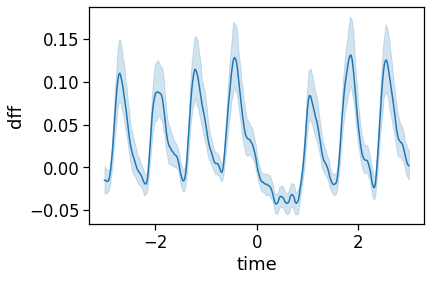

In [18]:
fig, ax = plt.subplots()
sns.lineplot(
    data=etr_df,
    x="time",
    y="dff",
    n_boot=500,
    ax=ax,
)

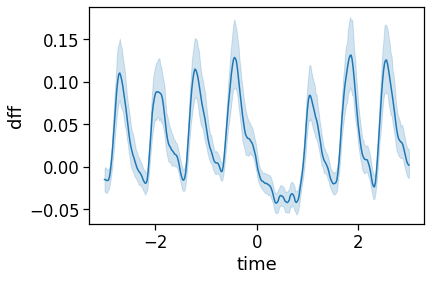

In [19]:
helper.plot_etr_df(etr_df)

  0%|          | 0/10 [00:00<?, ?it/s]

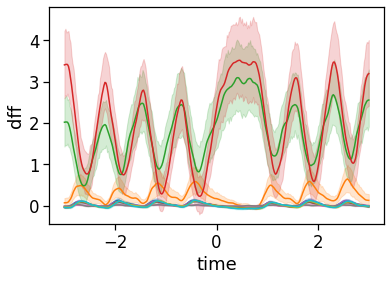

In [20]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    etr_df = helper.get_etr_df(
        neural_df = neural_df.query('cell_specimen_id == @cell_id'),
        t='timestamps',
        y='dff',
        event_times=stimulus_df.query('omitted')['start_time'],
        t_before=3,
        t_after=3,
        output_sampling_rate=50,
    )
    helper.plot_etr_df_on_axes(ax, etr_df)

In [21]:
mean_dff_by_experiment = (
    neural_df
        .groupby(['ophys_experiment_id','timestamps'])['dff']
        .mean()
        .reset_index()
)

  0%|          | 0/6 [00:00<?, ?it/s]

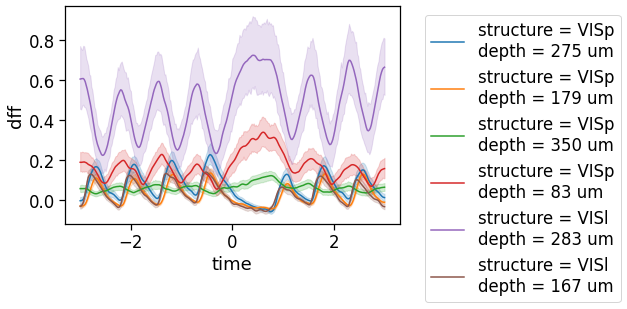

In [22]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(helper.get_experiment_ids_from_session(ophys_session_id=854060305)):
    etr_df = helper.get_etr_df(
        neural_df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
        t='timestamps',
        y='dff',
        event_times=stimulus_df.query('omitted')['start_time'],
        t_before=3,
        t_after=3,
        output_sampling_rate=50,
    )
    helper.plot_etr_df_on_axes(ax, etr_df)
    
    # get some metadata to add to the legend
    this_exp = neural_df.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))

## Scratch

In [25]:
helper.session_table.head(5)

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


In [29]:
# helper.experiment_table.head(8)
helper.experiment_table.query("ophys_session_id == 951410079")

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920
951980481,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028357,VisualBehaviorMultiscope,225,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400972
951980486,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028360,VisualBehaviorMultiscope,300,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400869
